In [4]:
import numpy as np
import pandas as pd
from rootpyPickler import Unpickler
import shipLHC_conf as sndDet_conf
import SndlhcGeo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time

### Load up sipms and PDFs

In [5]:
simps_x = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_x_{}.txt".format(station))
    simps_x.append(data)

In [6]:
simps_y = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_y_{}.txt".format(station))
    simps_y.append(data)

In [9]:
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

In [7]:
PDFs_x = []
for station in range(1,6):
    for energy in energies:
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_x_{}.txt".format(energy,station)
        data = np.loadtxt(path)
        PDFs_x.append(data)

In [8]:

PDFs_y = []
for station in range(1,6):
    for energy in energies:
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_y_{}.txt".format(energy,station)
        data = np.loadtxt(path)
        PDFs_y.append(data)

In [26]:
PDFs_x = np.array(PDFs_x)

In [27]:
PDFs_x += 0.00005

In [28]:
PDFs_y = np.array(PDFs_y)

In [29]:
PDFs_y += 0.00005

### Manual energy reco for diagnostics

In [10]:
t1 = time.perf_counter()
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
reco_e_x = np.array([])
reco_e_y = np.array([])
reco_e_comb = np.array([])
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]



for true_e in energies:
    for event in range(1,101):
        
        sum_log_x = np.zeros(11)
        sum_log_y = np.zeros(11)
        sum_log_comb = np.zeros(11)


        for station in range(1,6):
            logL_x = []
            logL_y = []

            SiPM_counts_x = simps_x[station-1]

            hit_counts_x = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_295/pions_{}/PDF/events/hits_x_{}_{}.txt".format(true_e,station,event))

            SiPM_counts_y = simps_y[station-1]

            hit_counts_y = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_295/pions_{}/PDF/events/hits_y_{}_{}.txt".format(true_e,station,event))
            
            for num_e, energy in enumerate(energies,start=0):
                
                PDF_x = PDFs_x[((station-1)*11)+num_e]

                logL_x.append(np.sum(np.nan_to_num(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                       ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
    
                PDF_y = PDFs_y[((station-1)*11)+num_e]

                logL_y.append(np.sum(np.nan_to_num(((SiPM_counts_y-hit_counts_y)*np.log(1-PDF_y))+\
                                                       ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))

            sum_log_x += logL_x
            sum_log_y += logL_y

        reco_e_x = np.append(reco_e_x,energies[np.argmax(sum_log_x)])
        reco_e_y = np.append(reco_e_y,energies[np.argmax(sum_log_y)])
        reco_e_comb = np.append(reco_e_comb,energies[np.argmax(sum_log_y+sum_log_x)])
        
t2 = time.perf_counter()
print(t2-t1)

<ipython-input-10-6135a546f08f>:36: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-10-6135a546f08f>:41: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))


302.4747014339082


### Check how PDFs look

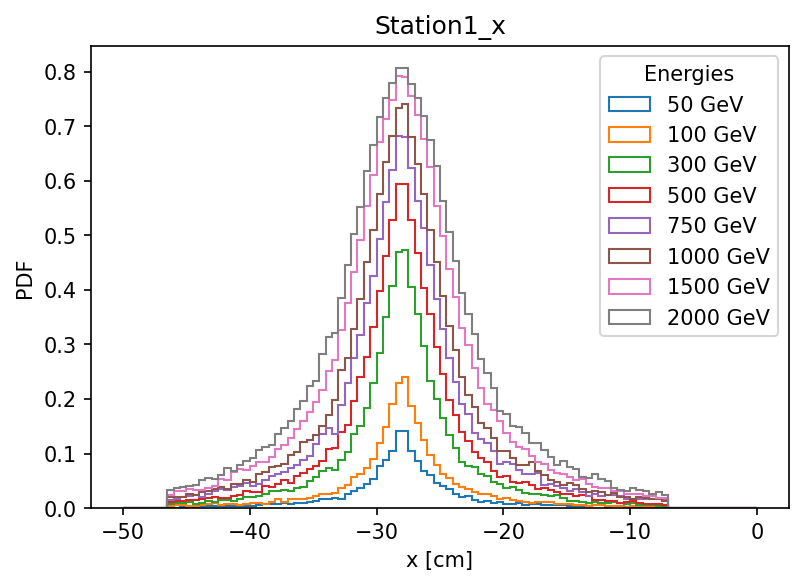

In [198]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for energy in [50,100,300,500,750,1000,1500,2000]:
    PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_x_3.txt".format(energy))
    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF,histtype="step",
                        label=[str(energy)+" GeV"])

plt.xlabel("x [cm]")
plt.ylabel("PDF")
plt.title("Station1_x")
plt.legend(title="Energies")

# plt.savefig("station1_x_energies.png")
plt.show()

### Single event hit distributions

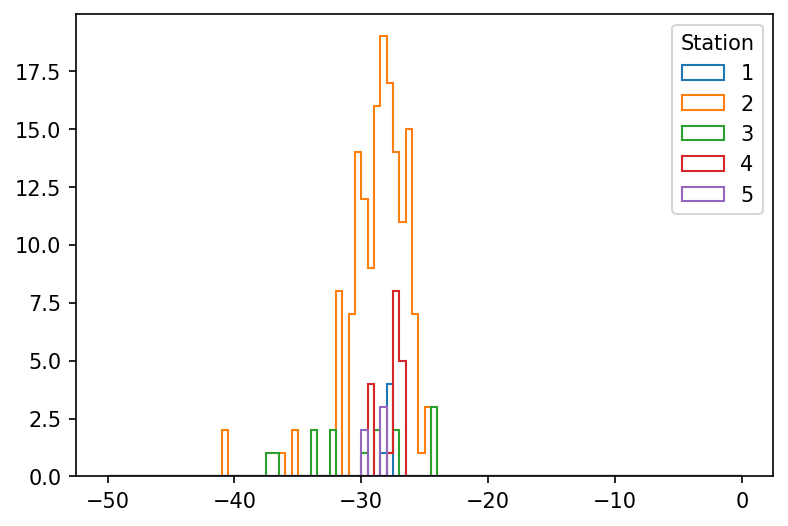

In [33]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

for station in range(1,6):

    hit_counts = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/events/hits_x_{}_{}.txt"\
                            .format(50,station,12))

    plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=hit_counts,histtype="step",label=station)
    
plt.legend(title="Station")
plt.savefig("50 GeV hits(evt_12).png")
plt.show()

In [10]:
true_e = np.array([])
for e in energies:
    for i in range(0,100):
    
        true_e = np.append(true_e,e)

### Summary energy reconstruction per depth

In [12]:
for depth in [317]:
    reco_e_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/energy_reco/reco_e_x.txt".format(depth))
    reco_e_x = np.ndarray.flatten(reco_e_x.values)

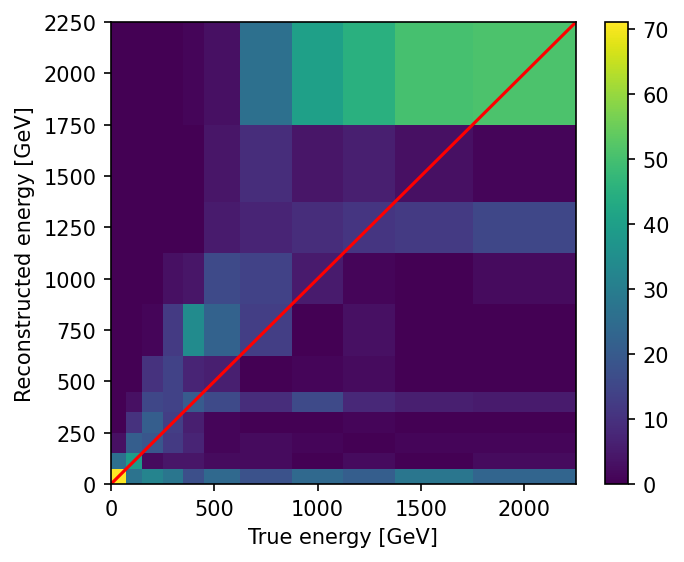

In [13]:
bins = [0,75,150,250,350,450,625,875,1125,1375,1750,2250]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_e,reco_e_x,bins = [bins,bins])
plt.ylabel("Reconstructed energy [GeV]")
plt.xlabel("True energy [GeV]")

# plt.colorbar(title="Number of events")
plt.colorbar()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")

# plt.tight_layout()
# plt.savefig("Energy_reco_z_317(100 events per e), x only (diagonal line).png",bbox_inches="tight")
# plt.xticks(energies)
# plt.yticks(energies)
plt.show()

### Breaking down energy reco for individual events

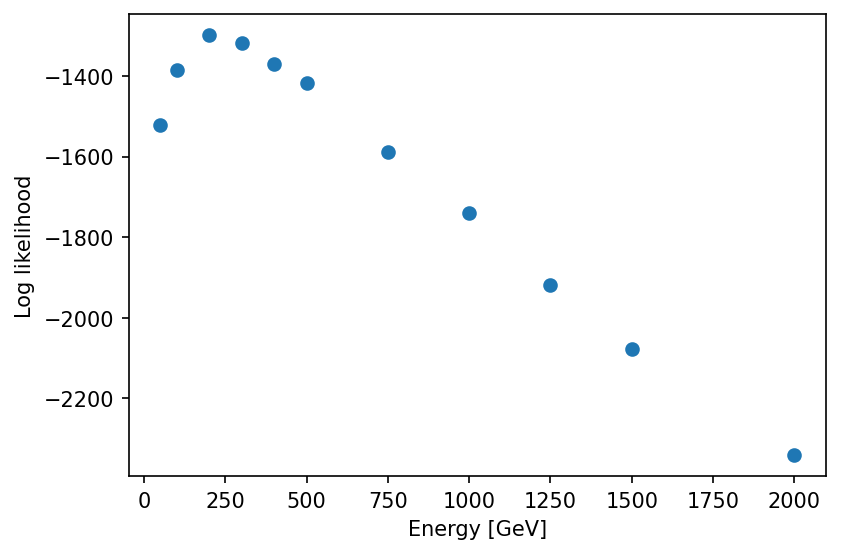

In [46]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

plt.scatter([50,100,200,300,400,500,750,1000,1250,1500,2000],sum_log_x)
plt.ylabel("Log likelihood")
plt.xlabel("Energy [GeV]")
# plt.legend(title="Station")
# plt.savefig("combined logL for 291cm 300 GeV example (evt_4).png",bbox_inches="tight")
plt.show()

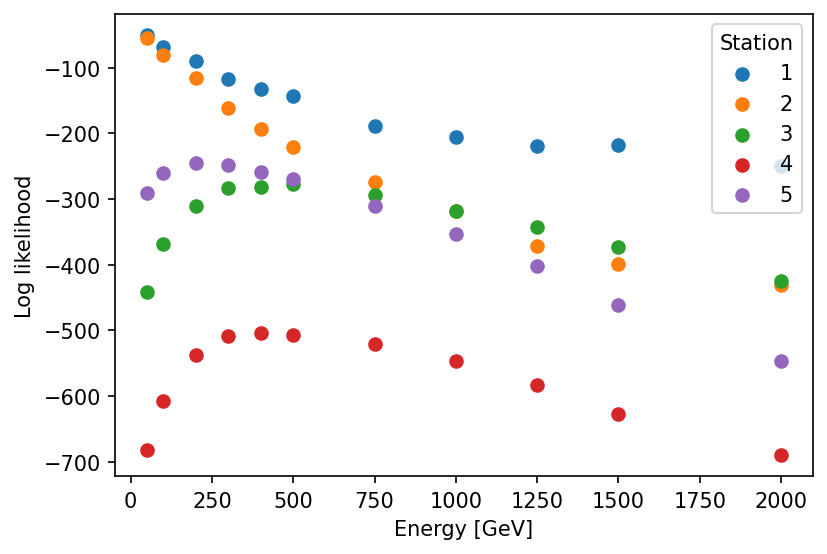

In [44]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for i in range(0,5):

    plt.scatter([50,100,200,300,400,500,750,1000,1250,1500,2000],log_x_list[i],label=i+1)
plt.ylabel("Log likelihood")
plt.xlabel("Energy [GeV]")
plt.legend(title="Station")
# plt.savefig("per station logL for 291cm 300 GeV example (evt_4).png",bbox_inches="tight")
plt.show()